In [1]:
import sympy as sp
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
# from sympy.abc import M, I
import math
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

init_vprinting()

## Rotation matrices

In [261]:
M, m = sp.symbols('M m', real=True, positive=True)
L = sp.symbols('L', real=True, positive=True)

phi, theta =  dynamicsymbols('phi theta')
beta, c = sp.symbols('beta c', real=True, positive=True)

g = sp.Symbol('g', real=True)
t = sp.Symbol('t')

# Rotation matrices 
B_R_P = sp.rot_axis3(phi)
A_R_B = sp.rot_axis1(sp.pi/2 - beta) 

## Angular velocities

### Plate

In [3]:
B_omega  = sp.Matrix([[0],[0],[phi.diff(t)]])
A_omega  = sp.Matrix([[0],[0],[theta.diff(t)]])

I_omega_p = A_omega + A_R_B  * B_omega
I_omega_p

⎡     0      ⎤
⎢            ⎥
⎢  cos(β)⋅φ̇  ⎥
⎢            ⎥
⎣sin(β)⋅φ̇ + θ̇⎦

### Rods

In [4]:
I_omega_rod1 = sp.Matrix([[0],[0],[theta.diff(t)]])

B_omega_rod2  = sp.Matrix([[0],[0],[phi.diff(t)]])
I_omega_rod2 = I_omega_rod1 + A_R_B  * B_omega_rod2

## Linear Velocities

### Plate

In [5]:
I_v_ba = sp.Matrix([[L*theta.diff(t)],[0],[0]])
I_r_pb = A_R_B *  B_R_P * sp.Matrix([[0],[L/2],[L/2]])

# # for verification 
# I_r_pb.subs({beta:sp.pi/2, phi:sp.pi/2})

I_v_po =  I_v_ba  + I_omega_p.cross(I_r_pb)
I_v_po.applyfunc(sp.simplify)

⎡L⋅(-sin(β)⋅cos(φ)⋅θ̇ - cos(β)⋅θ̇ - cos(φ)⋅φ̇ + 2⋅θ̇)⎤
⎢────────────────────────────────────────────────⎥
⎢                       2                        ⎥
⎢                                                ⎥
⎢            L⋅(sin(β)⋅φ̇ + θ̇)⋅sin(φ)             ⎥
⎢            ───────────────────────             ⎥
⎢                       2                        ⎥
⎢                                                ⎥
⎢              -L⋅sin(φ)⋅cos(β)⋅φ̇                ⎥
⎢              ───────────────────               ⎥
⎣                       2                        ⎦

In [6]:
# Sanity checks

# check whether x and z velocoty components due to phi rotation form circular path with omega rotation added
I_v_po.subs({beta:0}).applyfunc(sp.simplify)

⎡L⋅(-cos(φ)⋅φ̇ + θ̇)⎤
⎢─────────────────⎥
⎢        2        ⎥
⎢                 ⎥
⎢   L⋅sin(φ)⋅θ̇    ⎥
⎢   ──────────    ⎥
⎢       2         ⎥
⎢                 ⎥
⎢  -L⋅sin(φ)⋅φ̇    ⎥
⎢  ────────────   ⎥
⎣       2         ⎦

### Rods

In [7]:
I_v_rod1 =  sp.Matrix([[(L/2)*theta.diff(t)],[0],[0]])
I_v_rod2 = sp.Matrix([[theta.diff(t) * (L + (L/2* sp.cos(beta))) ],[0],[0]])

# Lagrangian

In [8]:
def norm_sqrd(v):
    return sp.simplify(sp.Pow(v[0],2) + sp.Pow(v[1],2) + sp.Pow(v[2],2))

def elementwise_sqrd(v):
    return sp.Matrix([[sp.Pow(v[0],2)],[sp.Pow(v[1],2)],[sp.Pow(v[2],2)]]) 

## Kinetic energy

### Kinetic energy of plate

In [9]:
I_xx = (1/6) * M * sp.Pow(L,2)
I_yy = I_zz  = (1/12) * M * sp.Pow(L,2)
I_plate = sp.diag(I_xx, I_yy, I_zz)

T_linear_plate = 0.5 * M *  norm_sqrd(I_v_po)
T_angular_plate= 0.5 * sum(I_plate * elementwise_sqrd(I_omega_p))

T_plate = T_linear_plate + T_angular_plate

### Kinetic energy of rods

In [10]:
I_xx = 0
I_yy = I_zz  = (1/12) * m * sp.Pow(L,2)
I_rod = sp.diag(I_xx, I_yy, I_zz)

T_linear_rod1 = 0.5 * m *  norm_sqrd(I_v_rod1)
T_linear_rod2 = 0.5 * m *  norm_sqrd(I_v_rod2)

T_angular_rod1 = 0.5 * sum(I_rod * elementwise_sqrd(I_omega_rod1))
T_angular_rod2 = 0.5 * sum(I_rod * elementwise_sqrd(I_omega_rod2))

T_rod1 = T_linear_rod1 + T_angular_rod1
T_rod2 = T_linear_rod2 + T_angular_rod2

### Total kinetic energy

In [11]:
T = T_plate + T_rod1 + T_rod2
T

## Potential energy

In [12]:
V_plate = -M*g*L*sp.sin(beta)*sp.cos(phi)
V = V_plate
V

## Compute equation of motion

In [262]:
# damping coeff

# rayleigh's dissipation to model air drag
phi_lever = L/2
theta_lever =  L + (L*sp.cos(beta))/2
# D = (0.5*c*phi_lever*phi.diff(t)**2 + 0.5*c*theta_lever*theta.diff(t)**2)
D = -0.5*c*phi_lever*phi.diff(t)**2

Lg = T - V
Lg

### theta

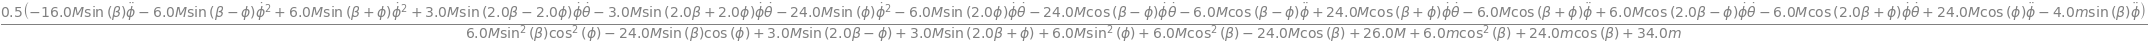

In [263]:
x = theta
xd = theta.diff(t)

EOM = sp.diff(sp.diff(Lg,xd), t) - sp.diff(Lg, x) + sp.diff(D, xd)

theta_eom = sp.simplify(EOM)

# equate to zero 
theta_eq = sp.Eq(theta_eom, 0)

# collect phi_ddot term 
theta_eq = sp.solve(theta_eq, theta.diff(t).diff(t))[0]
theta_eq

### phi

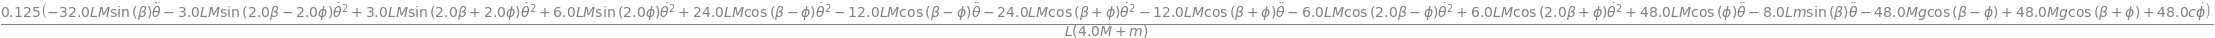

In [264]:
x = phi
xd = phi.diff(t)

EOM = sp.diff(sp.diff(Lg,xd), t) - sp.diff(Lg, x) + sp.diff(D, xd)

phi_eom = sp.simplify(EOM)

# equate to zero 
phi_eq = sp.Eq(phi_eom, 0)

# collect phi_ddot term 
phi_eq = sp.solve(phi_eq, phi.diff(t).diff(t))[0]

phi_eq

## Substitute physical values

In [265]:
params = {L:0.25, beta:np.pi/6, M:0.5, m:0.2, g:9.81, c:0.1}

### theta

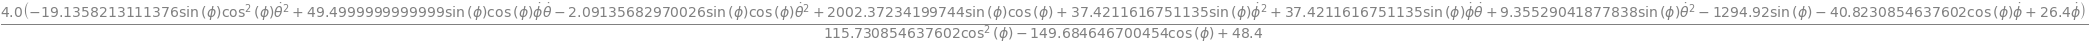

In [266]:
# substitute physical values 
theta_eq_ = theta_eq.subs(params )

# uncouple
theta_eq_ = sp.Eq(theta_eq_, 0)
theta_eq_ = theta_eq_.subs(phi.diff(t).diff(t), phi_eq)

# collect theta_ddot term 
theta_eq_ = sp.solve(theta_eq_, theta.diff(t).diff(t))[0]
theta_eq_final = theta_eq_.subs(params )

# theta_eq_final

theta_eq_final

In [267]:
theta_ddot_func = sp.lambdify((theta, phi, theta.diff(t), phi.diff(t)), theta_eq_final,  modules='numpy')

In [268]:
theta_ddot_func(10,np.pi/2, 0,0)

### phi

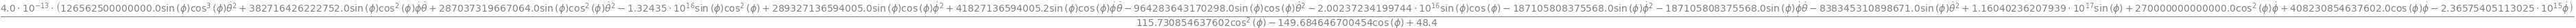

In [269]:
# substitute physical values 
phi_eq_ = phi_eq.subs(params )

# uncouple
phi_eq_ = sp.Eq(phi_eq_, 0)
phi_eq_ = phi_eq_.subs(theta.diff(t).diff(t), theta_eq)

# collect phi_ddot term 
phi_eq_ = sp.solve(phi_eq_, phi.diff(t).diff(t))[0]
phi_eq_final  = phi_eq_.subs(params ) 
phi_eq_final

In [270]:
phi_ddot_func = sp.lambdify((theta, phi, theta.diff(t), phi.diff(t) ), phi_eq_final,  modules='numpy')

In [271]:
phi_ddot_func(0, np.pi/4, 0,0)

## Simulation

In [272]:
def system_dynamics(t, X):
    phi = X[0]
    theta = X[1]

    phi_dot = X[2]
    theta_dot = X[3]


    phi_ddot = phi_ddot_func(theta,phi, theta_dot, phi_dot) 

    # # apply damping
    # phi_ddot -= 0.1*phi_ddot
    
    theta_ddot = theta_ddot_func(theta,phi, theta_dot, phi_dot)  
    
    return [phi_dot, theta_dot, phi_ddot, theta_ddot]

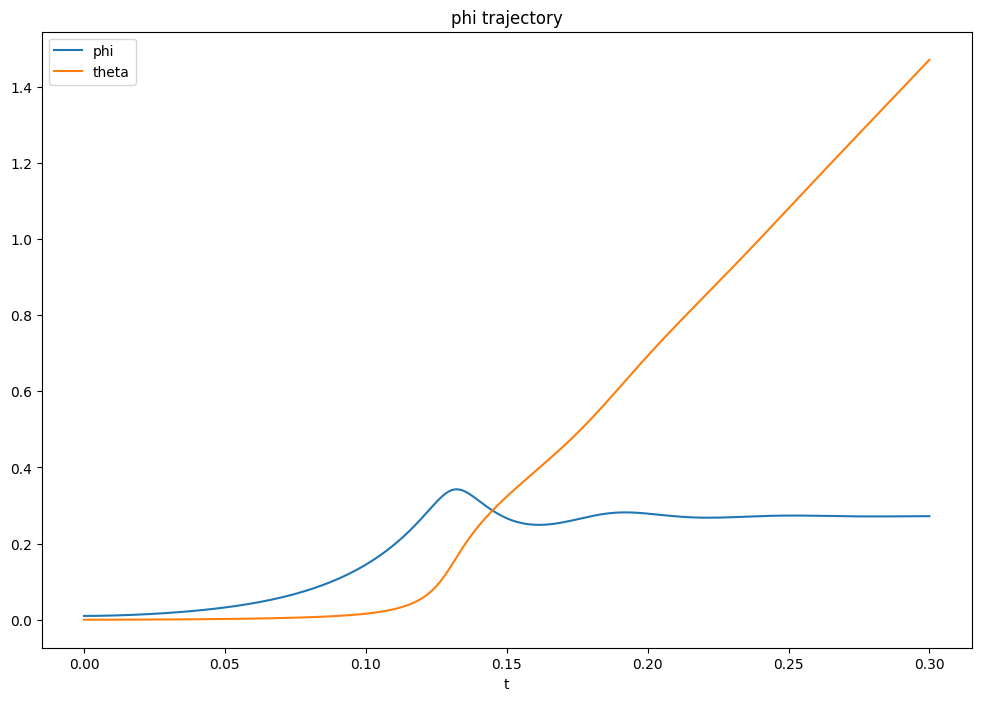

In [273]:
t_span = [0, 0.3]

# (phi, theta, phi_dot, theta_dot)
initial_conditions = [0.01,0.0,0.0,0]

sol = solve_ivp(system_dynamics, t_span , initial_conditions,  dense_output=True, rtol=1e-6, atol=1e-6)

# plotting
t = np.linspace(t_span[0], t_span[1], 300)
z = sol.sol(t)

plt.figure(figsize=(12,8))
plt.plot(t, z[0:2].T)
plt.xlabel('t')
plt.legend(['x', 'y'], shadow=True)
plt.title('phi trajectory')

# Function add a legend  
plt.legend(["phi","theta", "phi_dot", "theta_dot"])

plt.show()